In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import requests
import networkx as nx
from scipy.spatial.distance import euclidean
from Bio.PDB import PDBParser, PDBList
from torch_geometric.nn import GCNConv, GraphNorm, global_mean_pool


/Users/smallina/Desktop/Second Semester/BMI 707/BMI707FinalProject/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def fetch_alphafold_pdb(uniprot_id, save_dir="wt_pdbs"):
    os.makedirs(save_dir, exist_ok=True)
    url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"
    save_path = os.path.join(save_dir, f"{uniprot_id}.pdb")
    if not os.path.exists(save_path):
        r = requests.get(url)
        if r.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(r.content)
        else:
            raise ValueError(f"❌ Could not fetch AlphaFold PDB for {uniprot_id}")
    return save_path

In [3]:
def fetch_pdb_on_demand(pdb_id, save_dir="pdbs"):
    pdbl = PDBList()
    pdb_id = pdb_id.lower()
    os.makedirs(save_dir, exist_ok=True)
    filepath = pdbl.retrieve_pdb_file(pdb_id, pdir=save_dir, file_format='pdb')
    actual_pdb_path = os.path.join(save_dir, f"{pdb_id}.pdb")
    if not os.path.exists(actual_pdb_path):
        os.rename(filepath, actual_pdb_path)
    return actual_pdb_path

In [5]:
def extract_residue_coords(pdb_file, chain_id):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    model = structure[0]
    coords = {}
    for residue in model[chain_id]:
        if 'CA' in residue:
            res_id = residue.get_id()[1]
            coords[res_id] = residue['CA'].get_coord()
    return coords

In [6]:
def build_protein_graph(coords, distance_threshold=8.0):
    G = nx.Graph()
    residue_ids = list(coords.keys())
    for res_id in residue_ids:
        G.add_node(res_id, pos=coords[res_id])
    for i, id1 in enumerate(residue_ids):
        for id2 in residue_ids[i+1:]:
            dist = euclidean(coords[id1], coords[id2])
            if dist <= distance_threshold:
                G.add_edge(id1, id2, distance=dist)
    return G

In [7]:
def construct_graph_from_pdb(pdb_file, chain_id, distance_threshold=8.0):
    coords = extract_residue_coords(pdb_file, chain_id)
    return build_protein_graph(coords, distance_threshold)

In [8]:
def one_hot_encode_aa(aa):
    aa_list = list("ACDEFGHIKLMNPQRSTVWY")
    return [int(aa == x) for x in aa_list]

In [9]:
def enrich_graph_with_features(graph, row, sequence_length, mutate=False):
    sequence = row['sequence']
    catalytic = row['is_in_catalytic_pocket']
    essential = row['is_essential']
    mutation_pos = int(row['position'])
    mutant_aa = row['mutation']
    pdb_positions = sorted(graph.nodes)
    offset = min(pdb_positions)

    for pos in graph.nodes:
        seq_index = pos - offset
        if 0 <= seq_index < len(sequence):
            aa = sequence[seq_index]
            if mutate and pos == mutation_pos:
                aa = mutant_aa
            graph.nodes[pos]['aa_type'] = one_hot_encode_aa(aa)
            graph.nodes[pos]['is_catalytic'] = int(catalytic)
            graph.nodes[pos]['is_essential'] = int(essential)
            graph.nodes[pos]['relative_pos'] = pos / sequence_length
    return graph

In [10]:
def convert_nx_to_pyg(graph, ddG_value=0.0):
    features = []
    node_id_map = {}
    filtered_nodes = []
    for i, n in enumerate(graph.nodes):
        node_data = graph.nodes[n]
        if all(k in node_data for k in ['aa_type', 'is_catalytic', 'is_essential', 'relative_pos']):
            node_id_map[n] = len(filtered_nodes)
            filtered_nodes.append(n)
            feat = node_data['aa_type'] + [
                node_data['is_catalytic'],
                node_data['is_essential'],
                node_data['relative_pos']
            ]
            features.append(feat)
    if len(features) == 0:
        raise ValueError("No usable nodes with complete features.")
    edge_index, edge_attr = [], []
    for u, v, attrs in graph.edges(data=True):
        if u in node_id_map and v in node_id_map:
            edge_index.append([node_id_map[u], node_id_map[v]])
            edge_index.append([node_id_map[v], node_id_map[u]])
            edge_attr.append([attrs['distance']])
            edge_attr.append([attrs['distance']])
    if len(edge_index) == 0:
        raise ValueError("No valid edges in graph.")
    x = torch.tensor(features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    y = torch.tensor([ddG_value], dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [11]:
class DeltaDDGDataset(torch.utils.data.Dataset):
    def __init__(self, df, return_metadata=False):
        self.pairs = []
        self.meta = []
        self.return_metadata = return_metadata

        for _, row in df.iterrows():
            try:
                pdb_mut = fetch_pdb_on_demand(str(row['pdb_id']).split('|')[0].lower())
                pdb_wt = fetch_alphafold_pdb(row['uniprot_id'])

                G_mut = construct_graph_from_pdb(pdb_mut, row['chain'])
                G_mut = enrich_graph_with_features(G_mut, row, len(row['sequence']), mutate=True)
                data_mut = convert_nx_to_pyg(G_mut, row['ddG'])
                data_mut.batch = torch.zeros(data_mut.num_nodes, dtype=torch.long)

                G_wt = construct_graph_from_pdb(pdb_wt, 'A')
                G_wt = enrich_graph_with_features(G_wt, row, len(row['sequence']), mutate=False)
                data_wt = convert_nx_to_pyg(G_wt, row['ddG'])
                data_wt.batch = torch.zeros(data_wt.num_nodes, dtype=torch.long)

                self.pairs.append((data_wt, data_mut, torch.tensor(row['ddG'], dtype=torch.float)))
                self.meta.append(row.to_dict())  # ✅ Save full row metadata here
            except Exception as e:
                print(f"Skipping row due to error: {e}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        data = self.pairs[idx]
        if self.return_metadata:
            return data + (self.meta[idx],)  # ✅ Returns metadata only when asked
        else:
            return data



In [12]:
class ProteinGNNEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim,    hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)

        self.norm1 = GraphNorm(hidden_dim)
        self.norm2 = GraphNorm(hidden_dim)
        self.norm3 = GraphNorm(hidden_dim)
        self.norm4 = GraphNorm(hidden_dim)

        self.project = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch):
        x0 = F.relu(self.norm1(self.conv1(x, edge_index)))

        x1 = F.relu(self.norm2(self.conv2(x0, edge_index))) + x0

        x2 = F.relu(self.norm3(self.conv3(x1, edge_index))) + x1

        x3 = F.relu(self.norm4(self.conv4(x2, edge_index))) + x2

        h = global_mean_pool(x3, batch)

        return self.project(h)

In [13]:
class DeltaDDGPredictor(nn.Module):
    def __init__(self, encoder, embed_dim):
        super().__init__()
        self.encoder = encoder
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1)
)

    def forward(self, data_wt, data_mut):
        h_wt = self.encoder(data_wt.x, data_wt.edge_index, data_wt.batch)
        h_mut = self.encoder(data_mut.x, data_mut.edge_index, data_mut.batch)
        h_diff = h_mut - h_wt
        return self.regressor(h_diff).squeeze()

In [14]:
def train(model, optimizer, criterion, dataloader, device):
    model.train()
    total_loss = 0
    for data_wt, data_mut, ddg in tqdm(dataloader):
        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        optimizer.zero_grad()
        pred = model(data_wt, data_mut)
        loss = criterion(pred, ddg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * ddg.size(0)
    return total_loss / len(dataloader.dataset)

In [15]:
df = pd.read_csv("data/fireprotdb_results.csv")

/var/folders/kw/st1ymrwj7q923cvxxbj099fh0000gn/T/ipykernel_21268/180182367.py:1: DtypeWarning: Columns (23,24,25,26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/fireprotdb_results.csv")


In [16]:
columns_to_keep = [
        'experiment_id', 'protein_name', 'uniprot_id', 'pdb_id', 'chain',
        'position', 'wild_type', 'mutation', 'ddG', 'sequence',
        'is_in_catalytic_pocket', 'is_essential'
]
df = df[columns_to_keep].dropna().drop_duplicates(subset=['experiment_id'])

In [17]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = DeltaDDGDataset(df_train)
val_dataset = DeltaDDGDataset(df_val)

Structure exists: 'pdbs/pdb2afg.ent' 
Structure exists: 'pdbs/pdb2lzm.ent' 
Skipping row due to error: ❌ Could not fetch AlphaFold PDB for P00720
Structure exists: 'pdbs/pdb1mjc.ent' 
Structure exists: 'pdbs/pdb1tup.ent' 
Structure exists: 'pdbs/pdb2aky.ent' 
Structure exists: 'pdbs/pdb1shf.ent' 
Structure exists: 'pdbs/pdb1otr.ent' 
Structure exists: 'pdbs/pdb1vqb.ent' 
Skipping row due to error: ❌ Could not fetch AlphaFold PDB for P69543
Structure exists: 'pdbs/pdb1stn.ent' 
Structure exists: 'pdbs/pdb1amq.ent' 
Structure exists: 'pdbs/pdb1lz1.ent' 
Structure exists: 'pdbs/pdb2rn2.ent' 
Structure exists: 'pdbs/pdb1stn.ent' 
Structure exists: 'pdbs/pdb1bvc.ent' 
Structure exists: 'pdbs/pdb2hpr.ent' 
Structure exists: 'pdbs/pdb1rgg.ent' 
Structure exists: 'pdbs/pdb1pga.ent' 
Structure exists: 'pdbs/pdb2lzm.ent' 
Skipping row due to error: ❌ Could not fetch AlphaFold PDB for P00720
Structure exists: 'pdbs/pdb1wq5.ent' 
Structure exists: 'pdbs/pdb1wq5.ent' 
Structure exists: 'pdbs/pdb1w4

In [44]:
# Save the processed data tuples directly
torch.save(train_dataset.pairs, "train_dataset.pt")
torch.save(val_dataset.pairs, "val_dataset.pt")

AttributeError: 'list' object has no attribute 'pairs'

In [48]:
train_dataset= torch.load("train_dataset-2.pt", weights_only=False)
val_dataset  = torch.load("val_dataset-2.pt",   weights_only=False)


In [58]:
val = torch.load("val_dataset-2.pt", weights_only=False)
print(type(val)) 
for i, item in enumerate(val[:5]):
    print(i, type(item), item if i<2 else '...')


<class 'list'>
0 <class 'tuple'> (Data(x=[87, 23], edge_index=[2, 790], edge_attr=[790, 1], y=[1], batch=[87]), Data(x=[86, 23], edge_index=[2, 810], edge_attr=[810, 1], y=[1], batch=[86]), tensor(1.))
1 <class 'tuple'> (Data(x=[416, 23], edge_index=[2, 4292], edge_attr=[4292, 1], y=[1], batch=[416]), Data(x=[415, 23], edge_index=[2, 4258], edge_attr=[4258, 1], y=[1], batch=[415]), tensor(0.8400))
2 <class 'tuple'> ...
3 <class 'tuple'> ...
4 <class 'tuple'> ...


In [1]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = ProteinGNNEncoder(in_dim=23, hidden_dim=256, out_dim=128)
model   = DeltaDDGPredictor(encoder, embed_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

train_losses = []
val_losses = []
val_mse_scores = []
val_auc_scores = []

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data_wt, data_mut, ddg in dataloader:
            data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
            pred = model(data_wt, data_mut)
            loss = criterion(pred, ddg)
            total_loss += loss.item() * ddg.size(0)
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(ddg.view(-1).cpu().numpy())


    mse = criterion(torch.tensor(all_preds), torch.tensor(all_targets)).item()

    try:
        preds_tensor = torch.tensor(all_preds)
        preds_norm = (preds_tensor - preds_tensor.min()) / (preds_tensor.max() - preds_tensor.min() + 1e-6)
        targets_bin = [1 if x > 0 else 0 for x in all_targets]
        auc = roc_auc_score(targets_bin, preds_norm)
    except:
        auc = float('nan')

    return total_loss / len(dataloader.dataset), mse, auc

import math

for epoch in range(10):
    model.train()
    train_loss = train(model, optimizer, criterion, train_loader, device)
    train_losses.append(train_loss)
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")

    val_loss, val_mse, val_auc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_mse_scores.append(val_mse)
    val_auc_scores.append(val_auc)
    
    val_rmse = math.sqrt(val_mse)

    print(f"Epoch {epoch}, Val Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, AUC-ROC: {val_auc:.4f}")

import numpy as np

train_rmse_scores = [np.sqrt(loss) for loss in train_losses]
val_rmse_scores = [np.sqrt(mse) for mse in val_mse_scores]

plt.figure(figsize=(10, 5))
plt.plot(train_rmse_scores, label='Train RMSE')
plt.plot(val_rmse_scores, label='Validation RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train and Validation RMSE Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
    

NameError: name 'DataLoader' is not defined

In [19]:
import pandas as pd
import numpy as np

# assemble into a DataFrame
df_GNN_only_model_performance = pd.DataFrame({
    'epoch': np.arange(1, len(train_rmse_scores) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_rmse': train_rmse_scores,
    'val_rmse': val_rmse_scores,
    'val_mse': val_mse_scores,
    'val_auc': val_auc_scores,
})

# save as CSV
df_GNN_only_model_performance.to_csv('GNN_only_model_performance', index=False)

In [18]:
torch.save(model.state_dict(), "ddg_model_only.pt")

Pearson r = 0.391 (p=4.0e-75)
Spearman ρ = 0.424
R² = 0.133


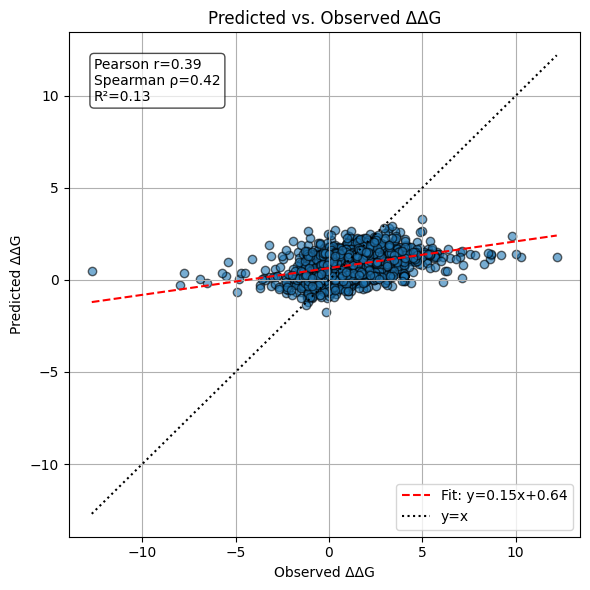

In [61]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 1) Gather preds & targets
preds, targets = [], []
model.eval()
with torch.no_grad():
    for data_wt, data_mut, ddg in val_loader:
        ddg = ddg.to(device)
        out = model(data_wt.to(device), data_mut.to(device))

        # Convert to numpy, flatten, then to list
        p = out.detach().cpu().numpy().flatten().tolist()
        t = ddg.detach().cpu().numpy().flatten().tolist()

        preds.extend(p)
        targets.extend(t)

preds   = np.array(preds)
targets = np.array(targets)

# 2) Compute metrics
pearson_r, pearson_p   = pearsonr(targets, preds)
spearman_rho, _        = spearmanr(targets, preds)
r2                     = r2_score(targets, preds)

print(f"Pearson r = {pearson_r:.3f} (p={pearson_p:.1e})")
print(f"Spearman ρ = {spearman_rho:.3f}")
print(f"R² = {r2:.3f}")

# 3) Plot with best‐fit
m, b = np.polyfit(targets, preds, 1)
x_line = np.linspace(targets.min(), targets.max(), 100)

plt.figure(figsize=(6,6))
plt.scatter(targets, preds, alpha=0.6, edgecolor='k')
plt.plot(x_line, m*x_line + b, 'r--', label=f'Fit: y={m:.2f}x+{b:.2f}')
plt.plot(x_line, x_line, 'k:', label='y=x')
plt.xlabel("Observed ΔΔG")
plt.ylabel("Predicted ΔΔG")
plt.title("Predicted vs. Observed ΔΔG")
plt.legend(loc="best")
plt.text(0.05, 0.95,
         f"Pearson r={pearson_r:.2f}\nSpearman ρ={spearman_rho:.2f}\nR²={r2:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.grid(True)
plt.tight_layout()
plt.show()